The aim is to identify instances of road flooding. This project utilizes transfer learning with pretrained TensorFlow models (from TensorFlow Hub), specifically Mobilenet_v2 and Inception_v3.


## Setup

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime



In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


## Transfer learning

data_root is the folder in Google Drive with the dataset.

There are two classes, with the images separed in two folders.

The structure should be like the one bellow:

data_root

.

├── traffic

│   ├── traffic_images.jpg

│   ├── ...

├── low_traffic

│   ├── low_traffic_images.jpg

│   ├── ...

In [3]:
data_root = '/content/drive/MyDrive/your_folder/'

In [4]:
# creating the training and validation datasets

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)


Found 4743 files belonging to 2 classes.
Using 3795 files for training.
Found 4743 files belonging to 2 classes.
Using 948 files for validation.


The traffic dataset has 2 classes:

In [5]:
class_names = np.array(train_ds.class_names)
print(class_names)

['low_traffic' 'traffic']


Because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.  Finish the input pipeline by using buffered prefetching with Dataset.prefetch, so you can yield the data from disk without I/O blocking issues.

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [9]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [10]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [11]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [12]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
predictions = model(image_batch)

In [14]:
predictions.shape

TensorShape([32, 2])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


Now use the `Model.fit` method to train the model.


In [16]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

NUM_EPOCHS = 10

early_stopping = EarlyStopping(monitor='val_acc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping])


Epoch 1/10
119/119 [==============================] - 1913s 16s/step - loss: 0.3571 - acc: 0.8559 - val_loss: 0.3105 - val_acc: 0.8819
Epoch 2/10
119/119 [==============================] - 10s 83ms/step - loss: 0.2754 - acc: 0.8875 - val_loss: 0.2861 - val_acc: 0.8861
Epoch 3/10
119/119 [==============================] - 11s 89ms/step - loss: 0.2499 - acc: 0.8964 - val_loss: 0.2762 - val_acc: 0.8903
Epoch 4/10
119/119 [==============================] - 10s 83ms/step - loss: 0.2342 - acc: 0.9043 - val_loss: 0.2711 - val_acc: 0.8924
Epoch 5/10
119/119 [==============================] - 10s 84ms/step - loss: 0.2231 - acc: 0.9096 - val_loss: 0.2686 - val_acc: 0.8935
Epoch 6/10
119/119 [==============================] - 10s 83ms/step - loss: 0.2146 - acc: 0.9128 - val_loss: 0.2678 - val_acc: 0.8914
Epoch 7/10
119/119 [==============================] - 10s 84ms/step - loss: 0.2077 - acc: 0.9178 - val_loss: 0.2682 - val_acc: 0.8966
Epoch 8/10
119/119 [==============================] - 10s 84m

Plotting the history of Accuracy and Loss, during training and validation

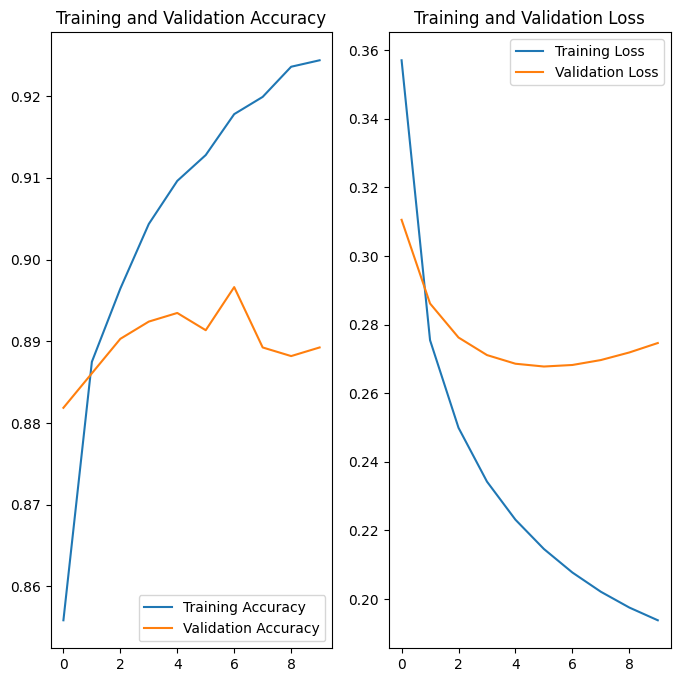

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [18]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 937ms/step
['traffic' 'low_traffic' 'traffic' 'low_traffic' 'low_traffic'
 'low_traffic' 'low_traffic' 'low_traffic' 'low_traffic' 'low_traffic'
 'low_traffic' 'low_traffic' 'low_traffic' 'traffic' 'low_traffic'
 'traffic' 'low_traffic' 'low_traffic' 'low_traffic' 'low_traffic'
 'low_traffic' 'low_traffic' 'traffic' 'low_traffic' 'low_traffic'
 'low_traffic' 'low_traffic' 'low_traffic' 'traffic' 'low_traffic'
 'traffic' 'low_traffic']


Plot the model predictions:

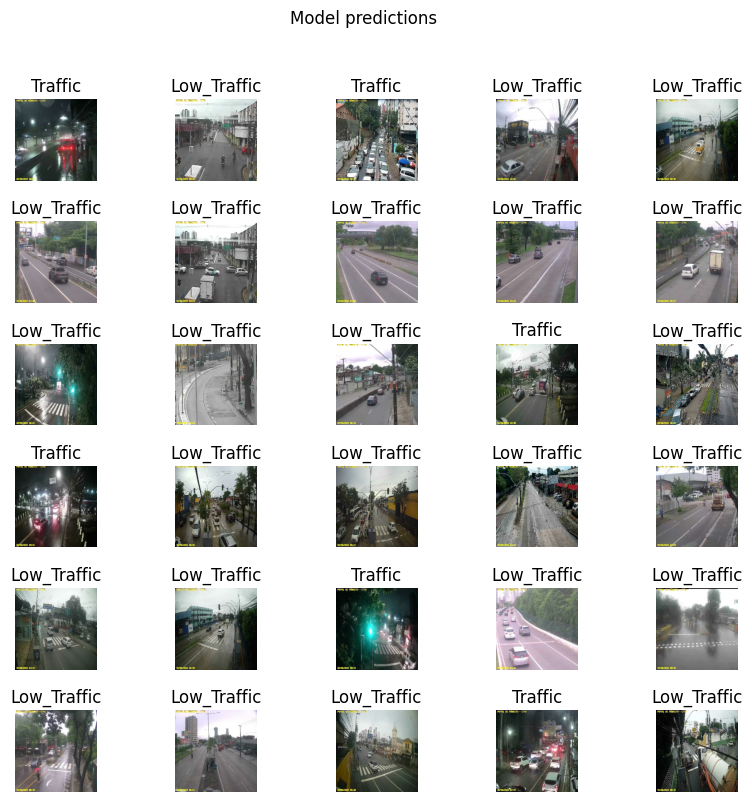

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

Calculating the Accuracy

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize empty lists for predicted labels and ground truth labels
predicted_labels = []
ground_truth_labels = []

# Iterate over the dataset and collect predicted and ground truth labels
for image_batch, label_batch in val_ds:
    # Obtain predicted class indices for the current batch
    predicted_batch = model.predict(image_batch)
    predicted_indices = np.argmax(predicted_batch, axis=-1)

    # Convert predicted indices to class labels
    predicted_labels.extend([class_names[i] for i in predicted_indices])

    # Convert ground truth indices to class labels
    ground_truth_labels.extend([class_names[i] for i in label_batch.numpy()])

# Calculate accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate confusion matrix
confusion_mat = confusion_matrix(ground_truth_labels, predicted_labels, labels=class_names)
print("Confusion Matrix:")
print(confusion_mat)


1/1 [==============================] - 1s 711ms/step
Accuracy: 0.8892405063291139
Confusion Matrix:
[[668  51]
 [ 54 175]]


## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [ ]:
from datetime import datetime

# Get the date and time
current_datetime = datetime.now()
datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Specify the file path where you want to save the model
export_path = f'/content/drive/MyDrive/your_folder/models/flooding_{datetime_string}.jpg'

model.save(export_path)

export_path

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [22]:
reloaded = tf.keras.models.load_model(export_path)

In [23]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 1s 852ms/step


In [24]:
abs(reloaded_result_batch - result_batch).max()

0.0